# Het notebook van Thomas Hendriks uit groep 4

In [1]:
import os
import time
import random
import collections

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torchvision
from torchvision.transforms import ToPILImage
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import tensorflow as tf
from tensorflow import io
from tensorflow import image
from warnings import filterwarnings
from tqdm.notebook import tqdm
import cv2

In [2]:
pad_naar_file = r"C:\Users\thoma\OneDrive\Bureaublad\IPDAMH\Image_Processing\sartorius-cell-instance-segmentation\train.csv"

In [3]:
df_orig = pd.read_csv(pad_naar_file)

In [4]:
df = df_orig.copy()


In [5]:
df

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
2,0030fd0e6378,173567 3 174270 5 174974 5 175678 6 176382 7 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
3,0030fd0e6378,196723 4 197427 6 198130 7 198834 8 199538 8 2...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
4,0030fd0e6378,167818 3 168522 5 169225 7 169928 8 170632 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
...,...,...,...,...,...,...,...,...,...
73580,ffdb3cc02eef,3610 3 4311 7 5014 9 5717 11 6420 13 7123 15 7...,704,520,cort,11h59m00s,2020-11-01,cort[debris]_D9-3_Vessel-384_Ph_4,0 days 11:59:00
73581,ffdb3cc02eef,341585 2 342287 5 342988 10 343690 13 344394 1...,704,520,cort,11h59m00s,2020-11-01,cort[debris]_D9-3_Vessel-384_Ph_4,0 days 11:59:00
73582,ffdb3cc02eef,47788 3 48490 7 49192 11 49896 13 50599 14 513...,704,520,cort,11h59m00s,2020-11-01,cort[debris]_D9-3_Vessel-384_Ph_4,0 days 11:59:00
73583,ffdb3cc02eef,333290 1 333993 2 334696 4 335399 5 336102 6 3...,704,520,cort,11h59m00s,2020-11-01,cort[debris]_D9-3_Vessel-384_Ph_4,0 days 11:59:00


## Data dictionary
id - unique identifier for object

annotation - run length encoded pixels for the identified neuronal cell

width - source image width

height - source image height

cell_type - the cell line

plate_time - time plate was created

sample_date - date sample was created

sample_id - sample identifier

elapsed_timedelta - time since first image taken of sample

### Data dictionary ###

| Variabele | Omschrijving | Datatype | Numeriek of Categorie | Meetniveau |
| :--- | :--- | :--- | :--- | :--- |
| Id | Een unieke identificatie code | Integer | Nummeriek | Ordinaal |
| annotation | gecodeerde pixels van een geïdentificeerde neuronen cell | object | Nummeriek | Ordinaal |
| width | breedte van de source image | Integer | Nummeriek | Interval |
| height | hoogte van de source image | Integer | Nummeriek | Interval |
| cell_type | Type van de cell | String | Catagorie | Nominaal |
| plate_time | Tijd van het maken van de sample | Time | Nummeriek | Interval |
| sample_date | Datum wanneer de sample is gemaakt | Date | Nummeriek | Interval |
| sample_id | Een unieke identificatie code van de sample | Integer | Catagorie | Ordinaal |
| elepased_timedelta | Tijd sinds eerste image is genomen | Date | Nummeriek | Ratio |

### Catagorische variabele

In [6]:
df['cell_type'].unique()

array(['shsy5y', 'astro', 'cort'], dtype=object)

In [7]:
df['plate_time'].unique()

array(['11h30m00s', '09h00m00s', '13h30m00s', '19h30m00s', '07h30m00s',
       '11h59m00s', '01h30m00s', '13h00m00s'], dtype=object)

In [8]:
df['sample_date'].unique()

array(['2019-06-16', '2020-09-13', '2020-11-04', '2020-10-27',
       '2020-11-07', '2019-06-14', '2019-06-15', '2020-11-03',
       '2020-11-06', '2020-10-30', '2020-11-05', '2020-09-15',
       '2020-09-16', '2020-09-14', '2020-09-12', '2020-10-26',
       '2020-11-01', '2020-10-29'], dtype=object)

In [9]:
df['elapsed_timedelta'].unique()

array(['0 days 11:30:00', '0 days 09:00:00', '0 days 13:30:00',
       '0 days 19:30:00', '0 days 07:30:00', '0 days 11:59:00',
       '0 days 01:30:00', '0 days 13:00:00'], dtype=object)

# Waardes verwijderen

Width en height zijn overal hetzelfde, dus kunnen worden verwijderd uit de dataset

ook zijn de tijd eenheden binnen de dataset niet nodig voor ons onderzoek. Daarom verwijderen we de plate_time, sample_date en elapsed_timedelta

In [10]:
def verwijder_kolommen(dataframe):
    
    dataframe = dataframe.drop(['width', 'height', 'plate_time', 'sample_date', 'elapsed_timedelta'], axis=1)
    
    return dataframe

In [11]:
verwijder_kolommen(df)

,id,annotation,cell_type,sample_id
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,shsy5y,shsy5y[diff]_E10-4_Vessel-714_Ph_3
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,shsy5y,shsy5y[diff]_E10-4_Vessel-714_Ph_3
2,0030fd0e6378,173567 3 174270 5 174974 5 175678 6 176382 7 1...,shsy5y,shsy5y[diff]_E10-4_Vessel-714_Ph_3
3,0030fd0e6378,196723 4 197427 6 198130 7 198834 8 199538 8 2...,shsy5y,shsy5y[diff]_E10-4_Vessel-714_Ph_3
4,0030fd0e6378,167818 3 168522 5 169225 7 169928 8 170632 9 1...,shsy5y,shsy5y[diff]_E10-4_Vessel-714_Ph_3
...,...,...,...,...
73580,ffdb3cc02eef,3610 3 4311 7 5014 9 5717 11 6420 13 7123 15 7...,cort,cort[debris]_D9-3_Vessel-384_Ph_4
73581,ffdb3cc02eef,341585 2 342287 5 342988 10 343690 13 344394 1...,cort,cort[debris]_D9-3_Vessel-384_Ph_4
73582,ffdb3cc02eef,47788 3 48490 7 49192 11 49896 13 50599 14 513...,cort,cort[debris]_D9-3_Vessel-384_Ph_4
73583,ffdb3cc02eef,333290 1 333993 2 334696 4 335399 5 336102 6 3...,cort,cort[debris]_D9-3_Vessel-384_Ph_4


In [12]:
pad_naar_file2 = r"C:\Users\thoma\OneDrive\Bureaublad\IPDAMH\Image_Processing\sartorius-cell-instance-segmentation\test\7ae19de7bc2a.png"
type(pad_naar_file2)

str

In [13]:
pad_naar_file3 = r"C:\Users\thoma\OneDrive\Bureaublad\IPDAMH\Image_Processing\sartorius-cell-instance-segmentation\test\d8bfd1dafdc4.png"
type(pad_naar_file3)

str

In [14]:
pad_naar_file4 = r"C:\Users\thoma\OneDrive\Bureaublad\IPDAMH\Image_Processing\sartorius-cell-instance-segmentation\test\d48ec7815252.png"
type(pad_naar_file4)

str

In [15]:
filterwarnings("ignore") 
tf_img = io.read_file(pad_naar_file2)
tf_img = image.decode_png(tf_img, channels=3)

In [16]:
tf_img1 = io.read_file(pad_naar_file3)
tf_img1 = image.decode_png(tf_img1, channels=3)

In [17]:
tf_img2 = io.read_file(pad_naar_file4)
tf_img2 = image.decode_png(tf_img2, channels=3)

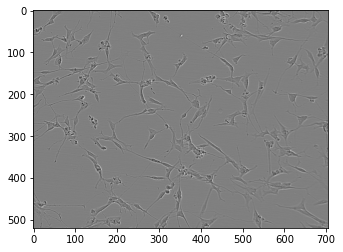

In [18]:
plt.imshow(tf_img)


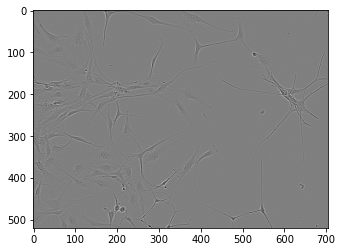

In [19]:
plt.imshow(tf_img1)

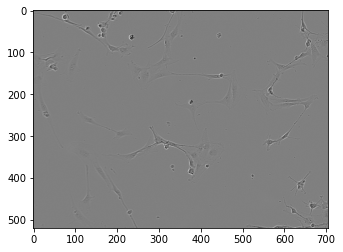

In [20]:
plt.imshow(tf_img2)

In [21]:
df["id"].value_counts(normalize=False)

c4121689002f    790
d164e96bb7a9    782
e748ac1c469b    703
aff8fb4fc364    609
e8ae919aa92e    605
               ... 
7f21996da2e6      8
c25db38e918e      6
b861811eaff6      5
eec79772cb99      5
e92c56871769      4
Name: id, Length: 606, dtype: int64

In [22]:
test_set_raw = r"C:\Users\thoma\OneDrive\Bureaublad\IPDAMH\Image_Processing\sartorius-cell-instance-segmentation\test"
train_set_raw = r"C:\Users\thoma\OneDrive\Bureaublad\IPDAMH\Image_Processing\sartorius-cell-instance-segmentation\train"
train_semi_set_raw = r"C:\Users\thoma\OneDrive\Bureaublad\IPDAMH\Image_Processing\sartorius-cell-instance-segmentation\train_semi_supervised"

In [23]:
def get_img(path):
    image_names = []
    for dirname, _, filenames in os.walk(path):
        for filename in tqdm(filenames):
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
        return image_names

In [24]:
def display_multiple_img(images_paths, rows, cols):
    """
    Function to Display Images from Dataset.
    
    parameters: images_path(string) - Paths of Images to be displayed
                rows(int) - No. of Rows in Output
                cols(int) - No. of Columns in Output
    """
    figure, ax = plt.subplots(nrows=rows,ncols=cols,figsize=(16,8) )
    for ind,image_path in enumerate(images_paths):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        try:
            ax.ravel()[ind].imshow(image)
            ax.ravel()[ind].set_axis_off()
        except:
            continue;
    plt.tight_layout()
    plt.show()

In [25]:
def Show_image(path):
    filterwarnings("ignore") 
    tf_img = io.read_file(path)
    tf_img = image.decode_png(tf_img, channels=3)
    #plt.imshow(tf_img)
    return tf_img

In [26]:
test_set = get_img(test_set_raw)
train_set = get_img(train_set_raw)
train_semi_set = get_img(train_semi_set_raw)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/606 [00:00<?, ?it/s]

  0%|          | 0/1972 [00:00<?, ?it/s]

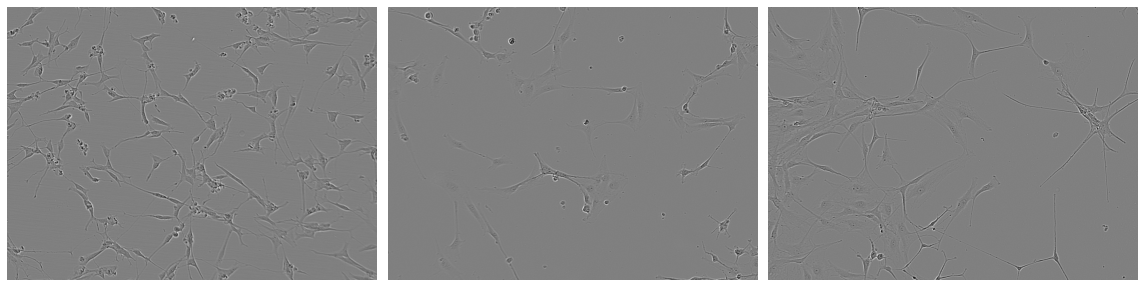

In [27]:
display_multiple_img(test_set,1,3)

# Mask

In [41]:
def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height, width, channels) of array to return 
    color: color for the mask
    Returns numpy array (mask)

    '''
    s = mask_rle.split()
    
    starts = list(map(lambda x: int(x) - 1, s[0::2]))
    lengths = list(map(int, s[1::2]))
    ends = [x + y for x, y in zip(starts, lengths)]
    
    img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
            
    for start, end in zip(starts, ends):
        img[start : end] = color
    
    return img.reshape(shape)

def build_masks(df, image_id, input_shape):
    height, width = input_shape
    labels = df[df["id"] == image_id]["annotation"].tolist()
    mask = np.zeros((height, width))
    for label in labels:
        mask += rle_decode(label, shape=(height, width))
    mask = mask.clip(0, 1)
    return mask

def plot_masks(image_id, colors=True):
    labels = df[df["id"] == image_id]["annotation"].tolist()
    cell_type = df[df["id"] == image_id]["cell_type"].tolist()
    cmap = {"shsy5y":(0,0,255),"astro":(0,255,0),"cort":(255,0,0)}

    if colors:
        mask = np.zeros((520, 704, 3))
        for label,cell_type in zip(labels,cell_type):
            c = cmap[cell_type]
            mask += rle_decode(label, shape=(520, 704, 3), color=c)
    else:
        mask = np.zeros((520, 704, 1))
        for label in labels:
            mask += rle_decode(label, shape=(520, 704, 1))
    mask = mask.clip(0, 1)

    image = cv2.imread(f"C:/Users/thoma/OneDrive/Bureaublad/IPDAMH/Image_Processing/sartorius-cell-instance-segmentation/train/{image_id}.png")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(16, 32))
    plt.subplot(3, 1, 1)
    plt.imshow(image)
    plt.axis("off")
    plt.subplot(3, 1, 2)
    plt.imshow(image)
    plt.imshow(mask, alpha=0.5)
    plt.axis("off")
    plt.subplot(3, 1, 3)
    plt.imshow(mask)
    plt.axis("off")
    
    plt.show();

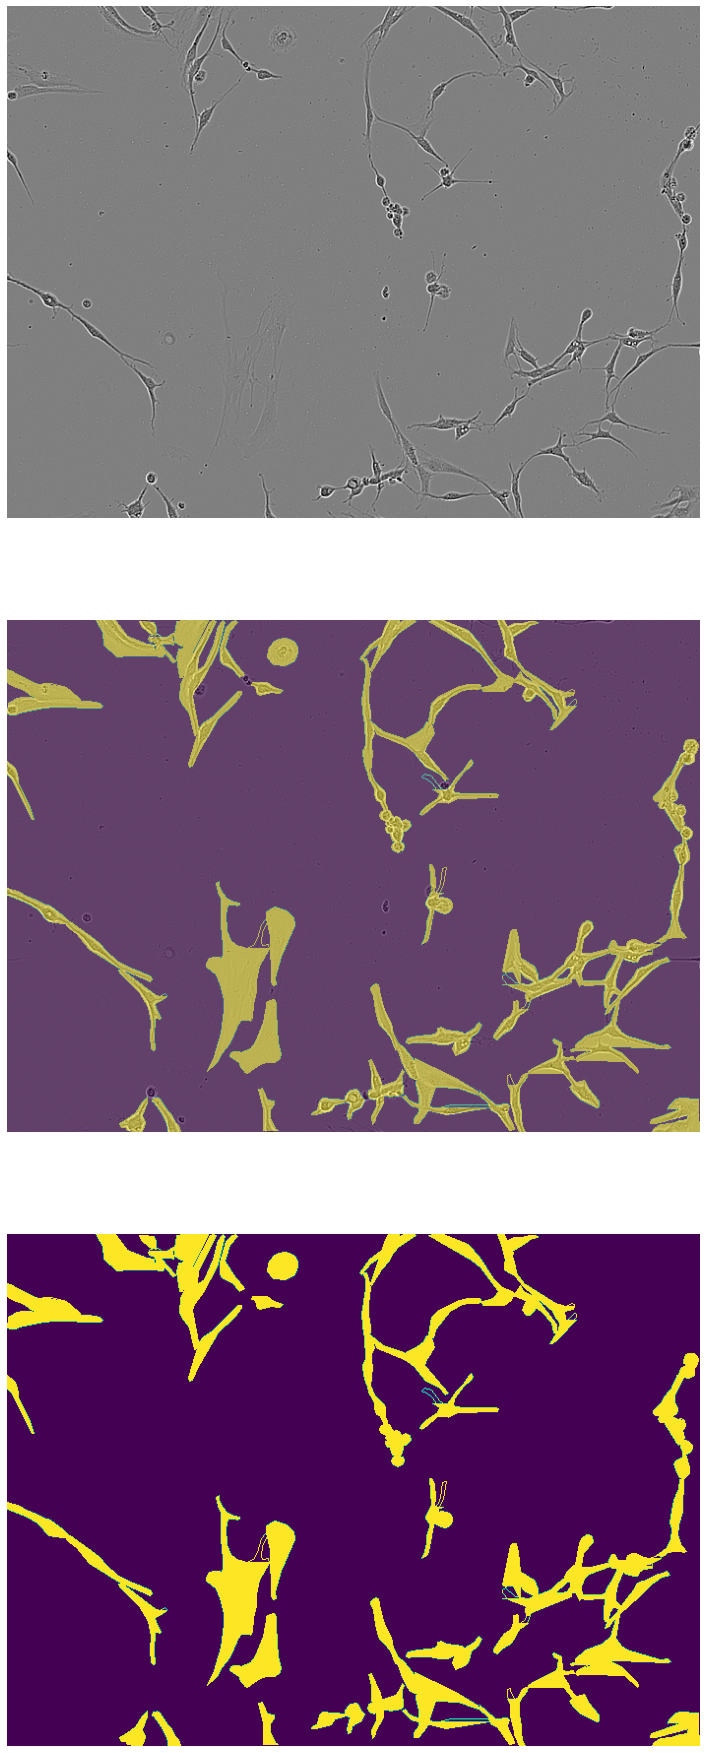

In [42]:
plot_masks("0c90b86742b2", colors=False)